In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [4]:
device = torch.device('cpu:0')

In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
# timestamp = 'May-03-2021_0134'
# timestamp = 'May-04-2021_0340'
# timestamp = 'May-09-2021_2309'
# timestamp = 'May-10-2021_1849'
timestamp = 'May-16-2021_1422'
# timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

In [5]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
fns = [fn for fn in fns if 'model_params' in fn]
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

['model_params_allROIs']
dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'covar_each_model_training', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'debug'])


In [6]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
covar_each_model_training = out['covar_each_model_training']
                                    
zscore_features = out['zscore_features']
# nonlin_fn = out['normalize_fn']
nonlin_fn = out['nonlin_fn']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

(11694, 3)
(11694, 432)


In [7]:
# For one example voxel, get its actual pRF parameters

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

from src.rf_grid import model_space_pyramid
# models is three columns, x, y, sigma
models = model_space_pyramid(logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)    

best_model_ind = np.where(np.sum(models==best_models[vidx],axis=1)==3)[0][0]
print(models[best_model_ind])

print(best_models[vidx])

# and get the features for each validation set trial, based on this pRF
val_features_actual = features_each_model_val[:,:,best_model_ind]
print(np.shape(val_features_actual))

[0.26052632 0.37631579 0.04      ]
[0.26052632 0.37631579 0.04      ]
(1491, 432)


In [8]:
# Getting the actual validation set data for this voxel of interest now

from src.load_nsd import image_uncolorize_fn, data_split, load_betas

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'    
beta_root = nsd_root + "nsddata_betas/ppdata/"
up_to_sess = 20

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
    
### LOADING DATA ####
print('Loading data for sessions 1:%d...'%up_to_sess)
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=up_to_sess, load_ext=".nii")
print('\nSize of full data set [nTrials x nVoxels] is:')
print(voxel_data.shape)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

data_size, n_voxels = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), voxel_data, ordering, imagewise=False)
n_trials_val = val_stim_single_trial_data.shape[0]
print(n_trials_val)

Loading data for sessions 1:20...
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.271, <sigma> = 1.348
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.136, <sigma> = 1.238
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.332, <sigma> = 1.340
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.064, <sigma> = 1.225
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.22

In [9]:
# predict validation set data based on saved weights and biases

weights = feature_weights[vidx,:]
print(np.shape(weights))
biases = best_params[2][vidx]
print(np.shape(biases))

val_resp_actual = val_voxel_single_trial_data[:,vidx:vidx+1]
# trn_resp_actual = trn_voxel_data[:,vidx]
# val_resp_predicted = val_features_actual @ weights + biases
feat = np.concatenate([val_features_actual, np.ones((np.shape(val_features_actual)[0],1))], axis=1)
w_full = np.expand_dims(np.append(weights, biases), axis=1)
val_resp_predicted = feat @ w_full
print(np.shape(val_resp_actual))
print(np.shape(val_resp_predicted))
est_corr = np.corrcoef(np.transpose(val_resp_actual), np.transpose(val_resp_predicted))[0,1]
print(est_corr)
print(val_cc[vidx])
print(best_lambdas[vidx])

(432,)
()
(1491, 1)
(1491, 1)
0.6938859810403483
0.693886
3


In [11]:

def _cofactor_fn_cpu(_x, lambdas):
    '''
    Generating a matrix needed to solve ridge regression model for each lambda value.
    Ridge regression (Tikhonov) solution is :
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    This func will return (X^T*X + I*lambda)^-1 * X^T. 
    So once we have that, can just multiply by training data (Y) to get weights.
    returned size is [nLambdas x nFeatures x nTrials]
    This version makes sure that the torch inverse operation is done on the cpu, and in floating point-64 precision.
    Otherwise get bad results for small lambda values. This seems to be a torch-specific bug.
    
    '''
    device_orig = _x.device
    type_orig = _x.dtype
    # switch to this specific format which works with inverse
    _x = _x.to('cpu').to(torch.float64)
    _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device='cpu', dtype=torch.float64) * l).inverse() for l in lambdas], axis=0) 
    
    # [#lambdas, #feature, #feature] 
    cof = torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    # put back to whatever way it was before, so that we can continue with other operations as usual
    return cof.to(device_orig).to(type_orig)



In [13]:
# solving for what the weights would be using validation set itself instead of trn set data 
# this is overfitting, but can give some intuition abt how fitting works...

from src.torch_fwrf import _to_torch, get_value, _loss_fn
import scipy

n_feat = np.shape(val_features_actual)[1]
feat = np.concatenate([val_features_actual, np.ones((np.shape(val_features_actual)[0],1))], axis=1)
# feat = np.concatenate([scipy.stats.zscore(val_features_actual,0), np.ones((np.shape(val_features_actual)[0],1))], axis=1)

_xval = _to_torch(feat, device=device)
# _cof = _cofactor_fn(_xval, lambdas, device=device)
_cof = _cofactor_fn_cpu(_xval, lambdas)
_vval = _to_torch(val_resp_actual, device=device)
_betas, _loss = _loss_fn(_cof, _vval, _xval, _vval) 
lind = np.argmin(get_value(_loss))
w_est = get_value(_betas[lind,:,0])

weights_from_val = w_est[0:n_feat]
bias_from_val = w_est[n_feat]

w_est_ols = get_value(_betas[0,:,0])

print(_cof[0,0:10,0])
print(w_est[0:5])
val_resp_predicted = feat @ w_est
print(np.corrcoef(np.transpose(val_resp_actual), np.transpose(val_resp_predicted))[0,1])

val_resp_predicted_ols = feat @ w_est_ols
print(np.corrcoef(np.transpose(val_resp_actual), np.transpose(val_resp_predicted_ols))[0,1])


tensor([ 13.6316, -10.9785,   5.9545,  -2.6589,   0.2066,   4.1208,  -9.3145,
          8.4508,  -2.4587,  -2.5950], device='cuda:0')
[  22.37836 -155.13484   55.15602   76.63234 -167.148  ]
0.7882269923621723
0.7882269923621723


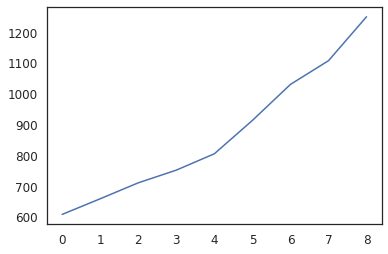

In [14]:
# want loss function to be monotonically related to lambda, for validation set (since no generalization)
plt.figure();plt.plot(_loss.cpu().detach().numpy())

Text(0, 0.5, 'activation in this example image')

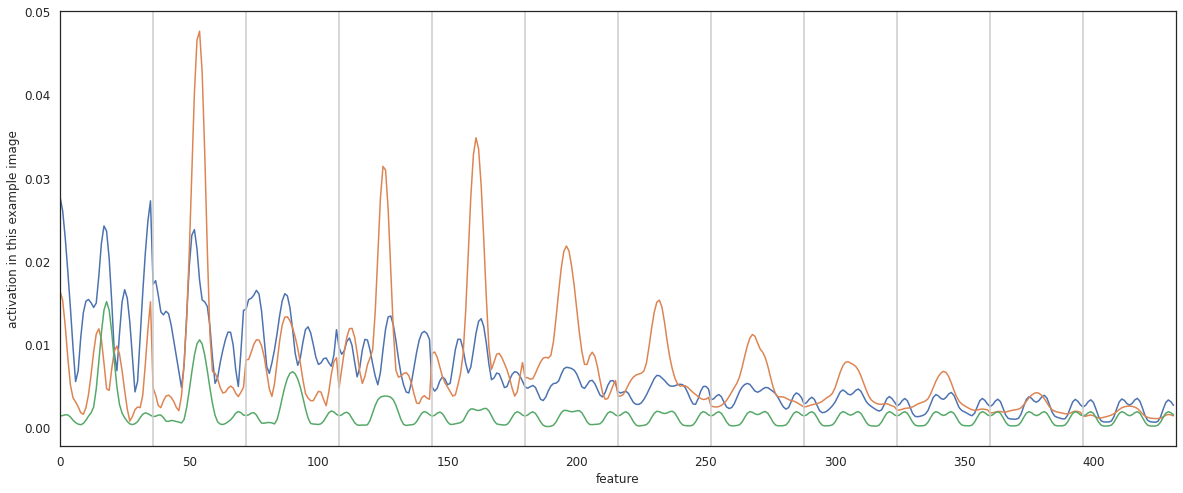

In [143]:
# Plotting activation each feature channel, for some individual images

plt.figure(figsize=(20,8));

image_idx = np.arange(0,3)
image_feats = val_features_actual[image_idx,:]

plt.plot(np.transpose(image_feats))
# plt.plot(weights_from_val*np.sqrt(vfeat)+mfeat)
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('activation in this example image')

Text(0, 0.5, 'weight (fit on validation set)')

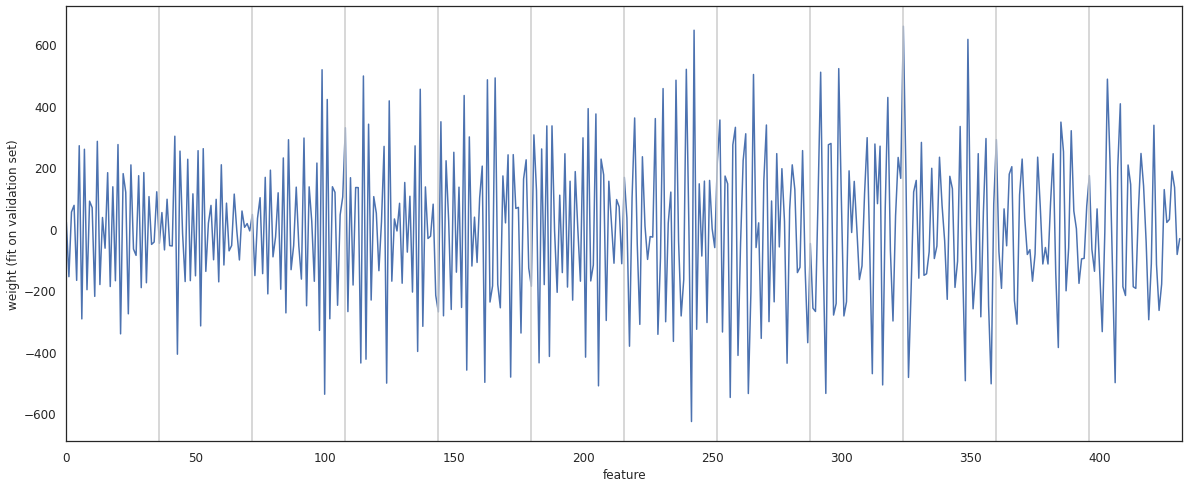

In [151]:
# Plotting encoding model wts versus features (computed on validation set )

plt.figure(figsize=(20,8));
plt.plot(weights_from_val)
# plt.plot(weights_from_val*np.sqrt(vfeat)+mfeat)
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('weight (fit on validation set)')

Text(0, 0.5, 'weight')

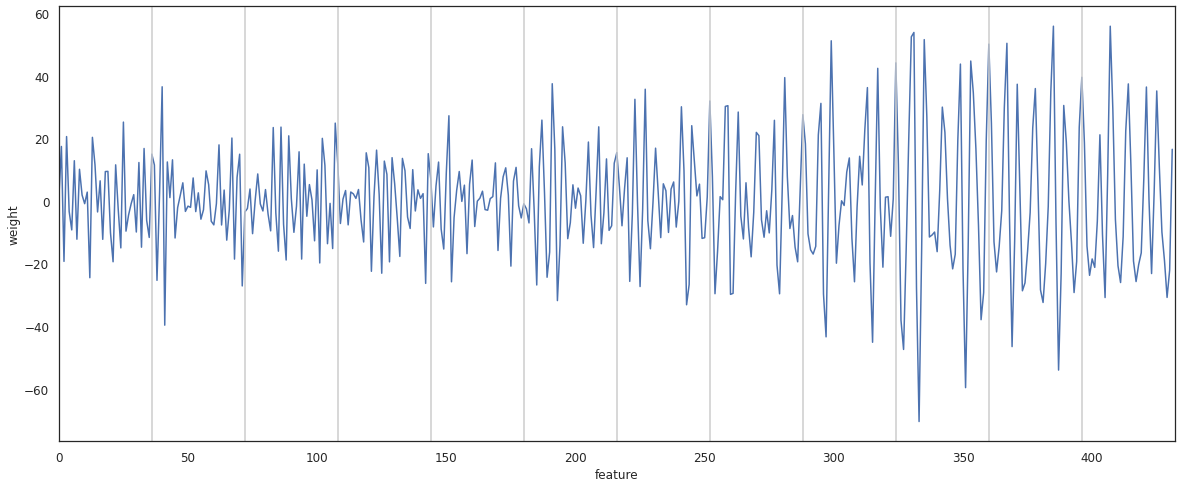

In [152]:
# Plotting encoding model wts versus features (training set)

plt.figure(figsize=(20,8));
plt.plot(weights)
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('weight')

Text(0, 0.5, 'voxel correlation with feature')

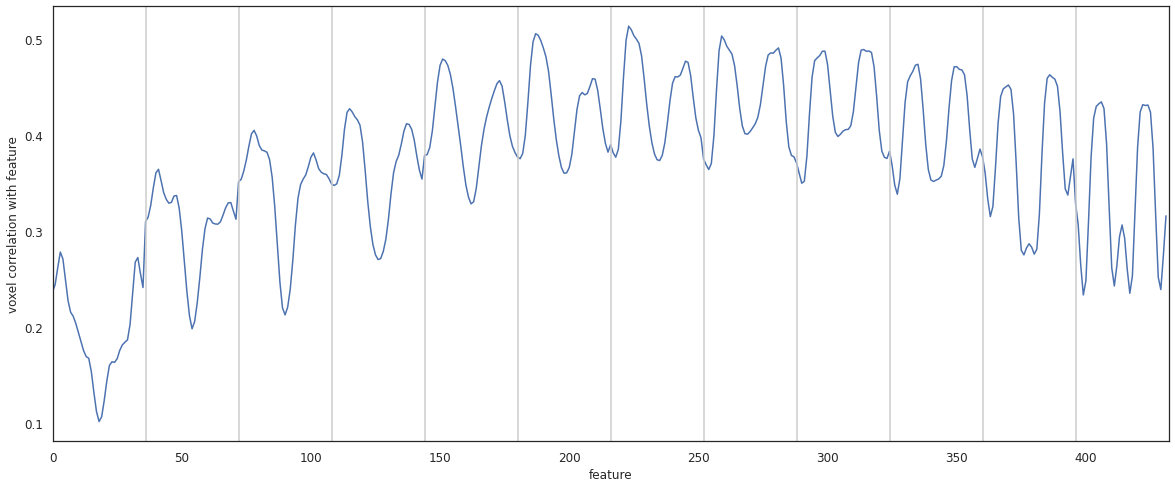

In [322]:
# Plotting correlation of voxel's resp with each feature channel (validation set)
# already computed/saved during fitting script

plt.figure(figsize=(20,8));
plt.plot(voxel_feature_correlations_val[vidx,:])
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('voxel correlation with feature')

Text(0, 0.5, 'trial')

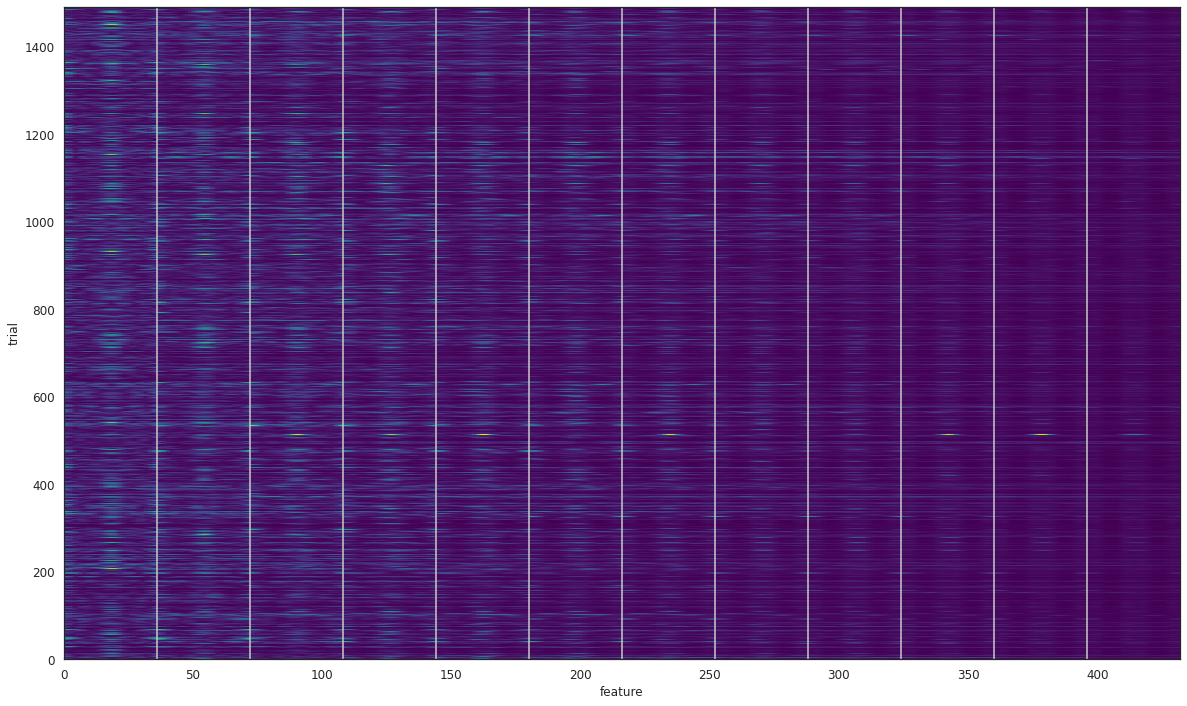

In [15]:
# visualizing ntrials x nfeatures (no z-score)

plt.figure(figsize=(20,12));
val_features_actual = features_each_model_val[:,:,best_model_ind]
plt.pcolormesh(val_features_actual)
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')

Text(0, 0.5, 'mean value across trials')

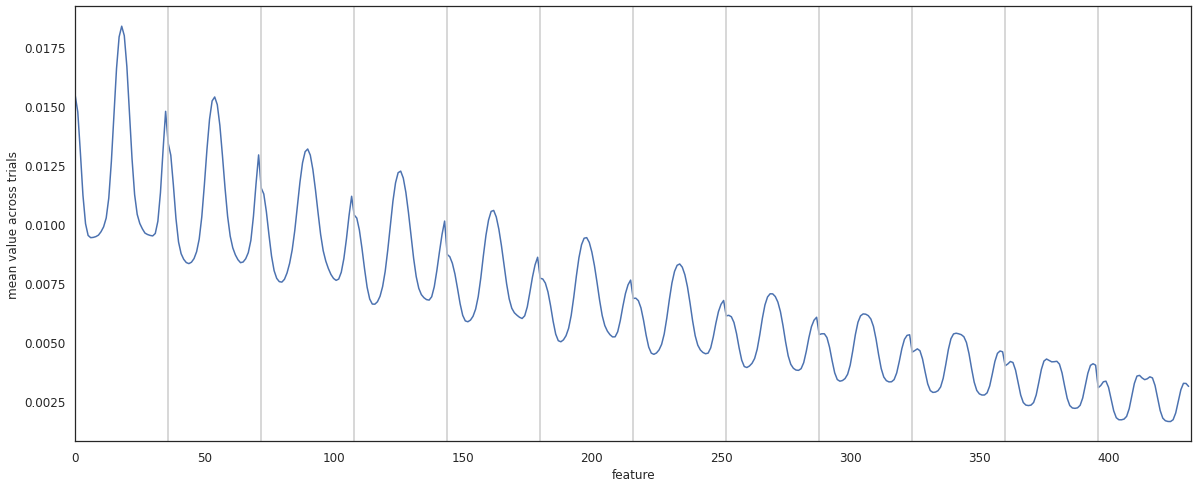

In [20]:
plt.figure(figsize=(20,8));
plt.plot(np.mean(val_features_actual,axis=0))
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('mean value across trials')

Text(0, 0.5, 'variance across trials')

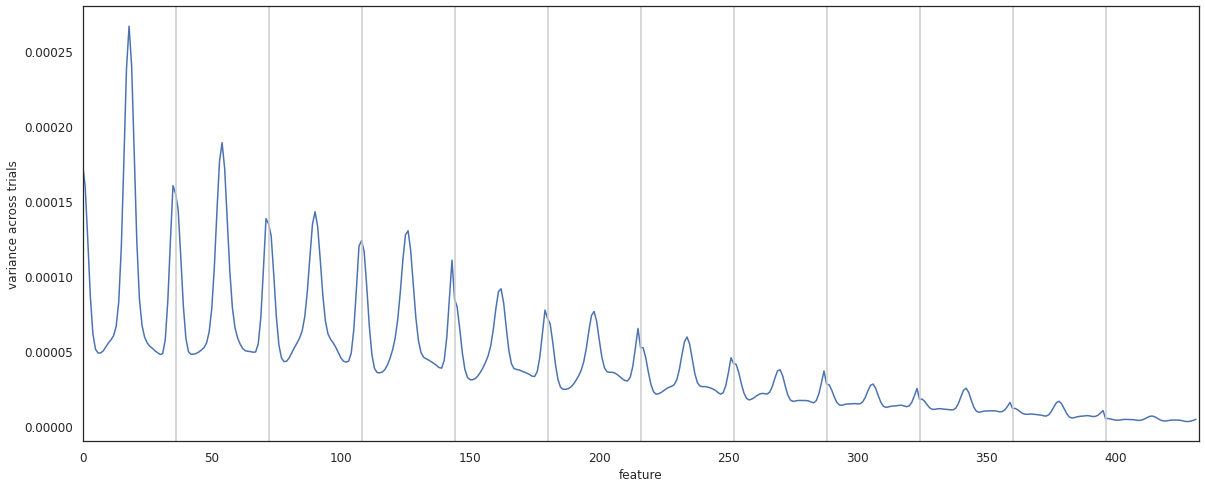

In [21]:
plt.figure(figsize=(20,8));
plt.plot(np.var(val_features_actual,axis=0))
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('variance across trials')

Text(0, 0.5, 'feature 2')

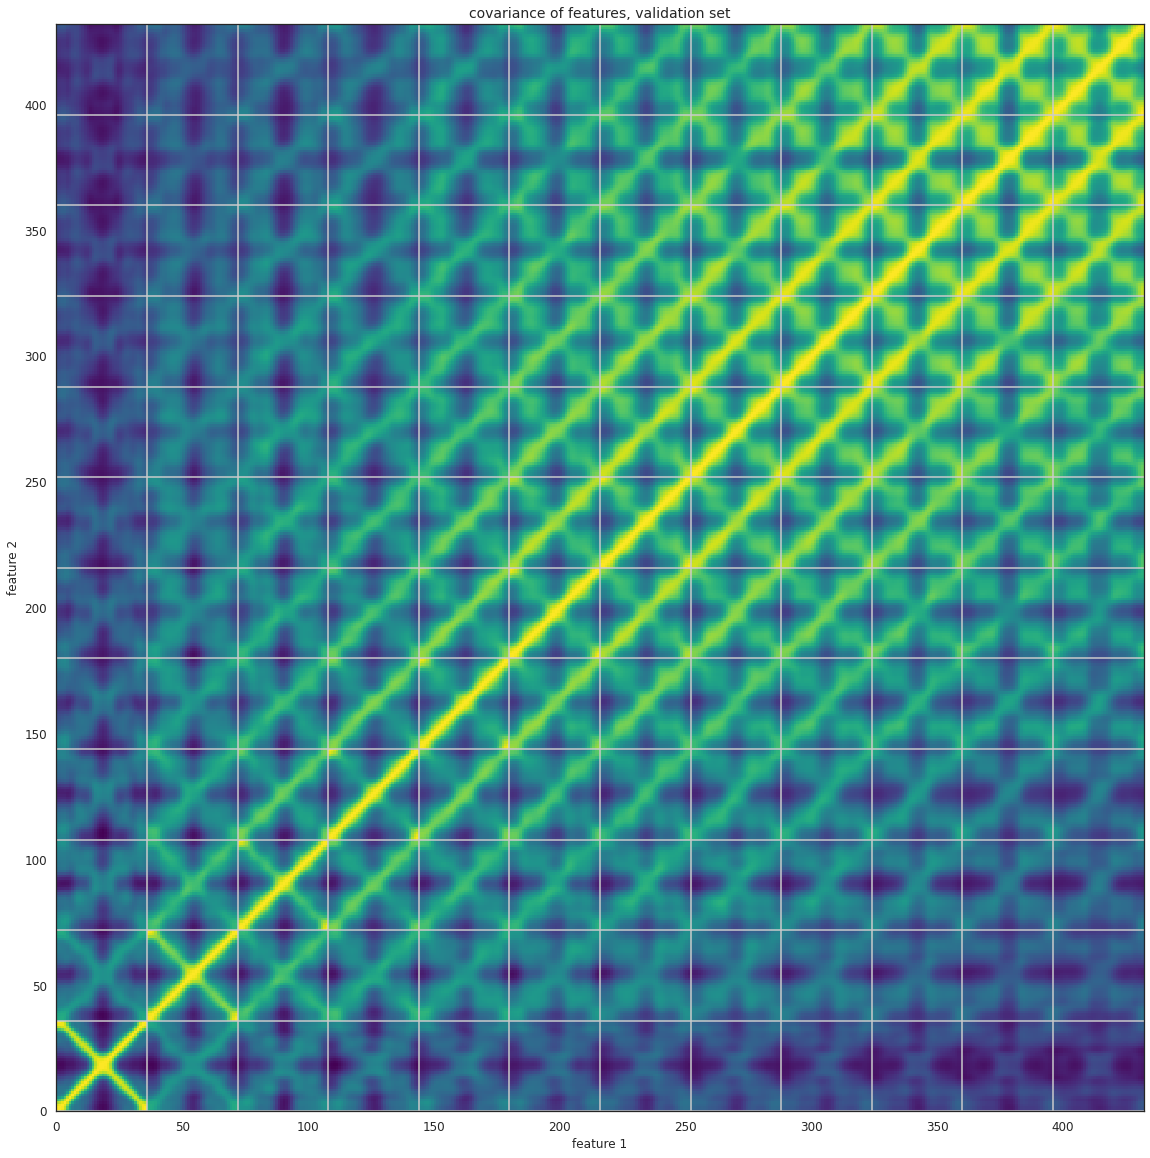

In [17]:

features_actual = features_each_model_val[:,:,best_model_ind]
features_actual = scipy.stats.zscore(features_each_model_val[:,:,best_model_ind], axis=0)
covariance = np.cov(np.transpose(features_actual))
plt.figure(figsize=(20,20));
plt.pcolormesh(covariance)
# plt.colorbar()
plt.axis('square')
plt.title('covariance of features, validation set')
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    plt.axhline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature 1')
plt.ylabel('feature 2')

In [76]:
# trying pca to decorrelate features...
from sklearn import decomposition
pca = decomposition.PCA()
# val_features_actual = scipy.stats.zscore( features_each_model_val[:,:,best_model_ind], axis=0)
val_features_actual = features_each_model_val[:,:,best_model_ind]
print('running pca (original size %d by %d)'%(np.shape(val_features_actual)[0], np.shape(val_features_actual)[1]))
pca.fit(val_features_actual)
scores = pca.transform(val_features_actual)
pca_wts = pca.components_
pct_expl_var = pca.explained_variance_
pct_expl_var = pct_expl_var/sum(pct_expl_var)*100

running pca (original size 1491 by 432)


432


Text(0, 0.5, 'cumulative var expl')

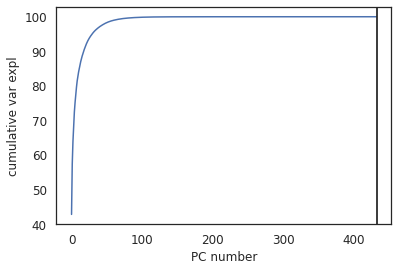

In [77]:
plt.figure();
plt.plot(np.cumsum(pct_expl_var))
# ncompneeded = np.where(np.cumsum(pct_expl_var)>99)[0][0]
ncompneeded = 432
feat_reduced = scores[:,0:ncompneeded]
plt.axvline(ncompneeded,color='k')
print(ncompneeded)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')

In [49]:
np.shape(pca.components_)


(432, 432)

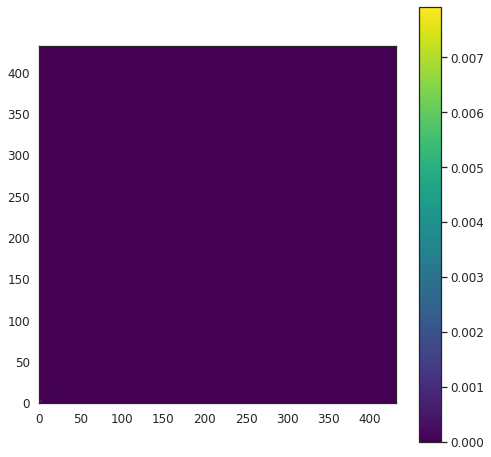

In [78]:

np.shape(feat_reduced)
cov_reduced = np.cov(np.transpose(feat_reduced))
plt.figure(figsize=(8,8));
plt.pcolormesh(cov_reduced)
plt.axis('square')
plt.colorbar()

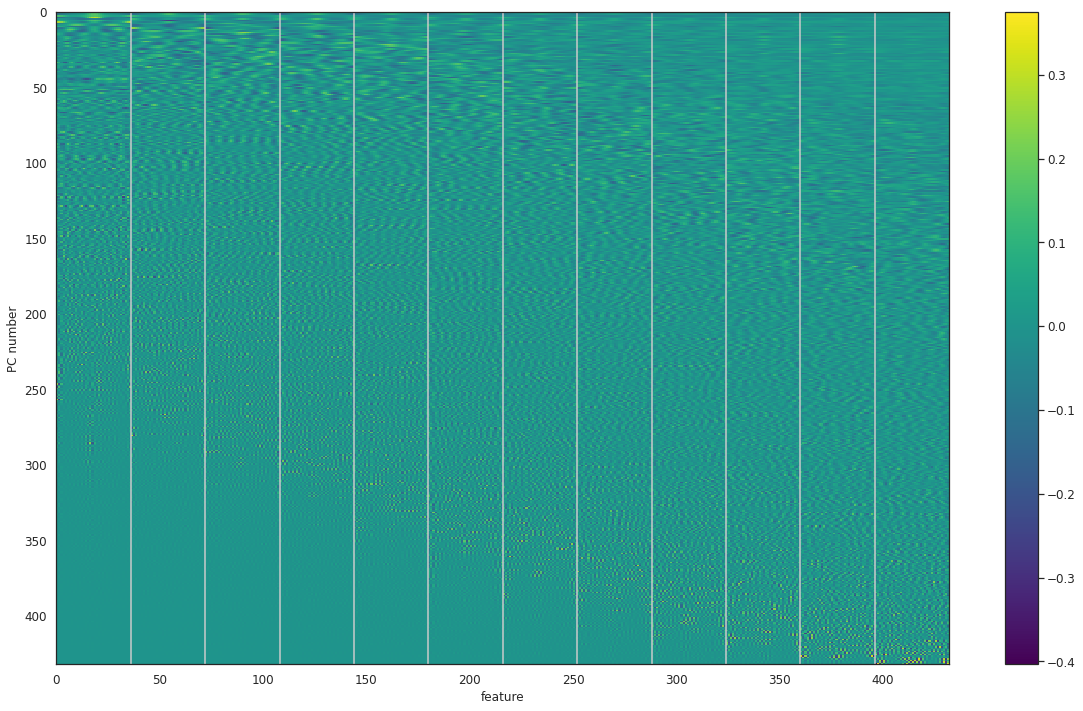

In [79]:
# visualizing ntrials x nfeatures (no z-score)

plt.figure(figsize=(20,12));
plt.pcolormesh(pca_wts[0:ncompneeded,:])
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0, 0.5, 'PC weight')

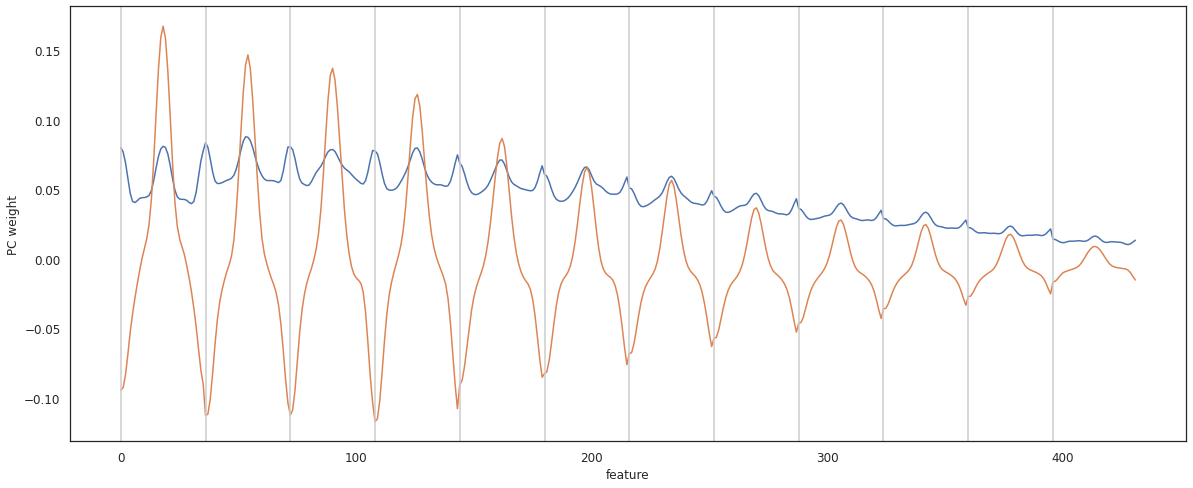

In [80]:
plt.figure(figsize=(20,8));
plt.plot(np.transpose(pca_wts[0:2,:]))
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC weight')

In [81]:
# Fitting based on reduced-dim features
import scipy

# z-score the features so they'll have equal variance...
# feat_reduced_z = feat_reduced
feat_reduced_z = scipy.stats.zscore(feat_reduced,axis=0)
feat = np.concatenate([feat_reduced_z, np.ones((np.shape(feat_reduced)[0],1))], axis=1)
n_feat_reduced = np.shape(feat_reduced)[1]

lambdas2use = [0.0, 0.0]
_xval = _to_torch(feat, device=device)
_cof = _cofactor_fn_cpu(_xval, lambdas2use)
_vval = _to_torch(val_resp_actual, device=device)
_betas, _loss = _loss_fn(_cof, _vval, _xval, _vval) 
lind = np.argmin(get_value(_loss))
w_est = get_value(_betas[lind,:,0])
print([lind, lambdas2use[lind]])
print(w_est[0:5])
weights_from_val = w_est[0:n_feat_reduced]
bias_from_val = w_est[n_feat_reduced]

val_resp_predicted = feat @ w_est
print(np.corrcoef(np.transpose(val_resp_actual), np.transpose(val_resp_predicted))[0,1])



[0, 0.0]
[ 0.5281574  -0.11295282 -0.19178955 -0.01477886  0.00502823]
0.8307239119801697


In [182]:
def solve_ols(x, y):
    
    weights = np.linalg.inv(np.transpose(x) @ x) @ np.transpose(x) @ y    
    return weights

def solve_ridge_regression(x, y, lamdba_value):
    
    nfeatures = np.shape(x)[1]    
    weights = np.linalg.inv(np.transpose(x) @ x + np.identity(nfeatures)*lambda_value) @ np.transpose(x) @ y    
   
    return weights

In [54]:
# just double checking regression solution, same as above 
w_est_ols = solve_ols(feat, val_resp_actual)
val_resp_predicted = feat @ w_est_ols
print(w_est_ols[0:5])
print(np.corrcoef(np.transpose(val_resp_actual), np.transpose(val_resp_predicted))[0,1])


NameError: name 'solve_ols' is not defined

Text(0, 0.5, 'weight (fit on validation set)')

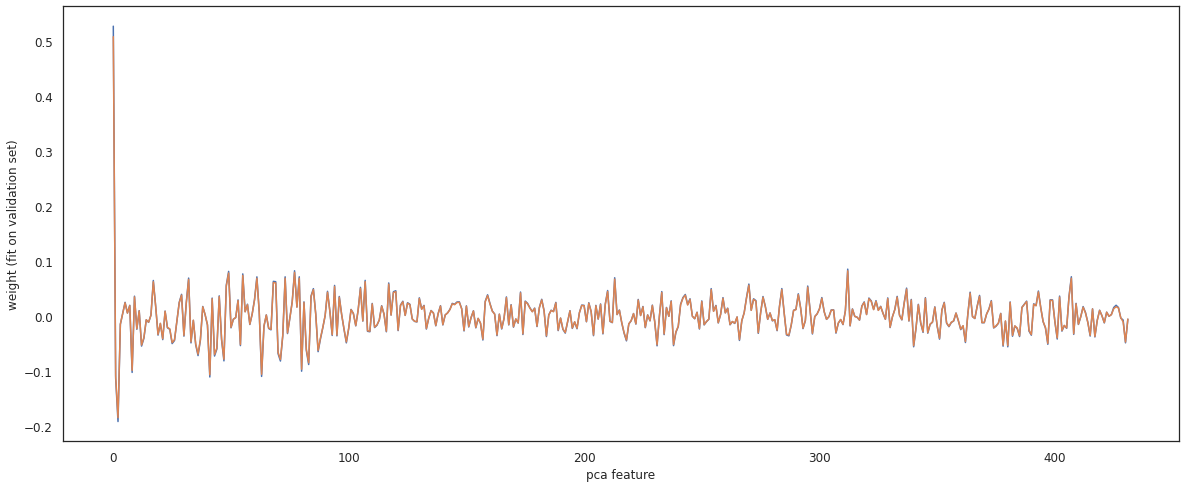

In [82]:
# Plotting encoding model wts versus features (computed on validation set )
# For pca'd, z-scored features, these are same.

plt.figure(figsize=(20,8));

plt.plot(weights_from_val)

# Assess the voxel's correlation w these reduced-dimensionality features

voxel_pcafeat_correlations_val = np.zeros((1, n_feat_reduced),dtype=fpX)
features2use = feat_reduced_z

for ff in range(n_feat_reduced):        
    voxel_pcafeat_correlations_val[0,ff] = np.corrcoef(features2use[:,ff], val_voxel_single_trial_data[:,vidx])[0,1]


plt.plot(voxel_pcafeat_correlations_val[0,:])

plt.xlabel('pca feature')
plt.ylabel('weight (fit on validation set)')

Text(0, 0.5, 'weight (fit on validation set)')

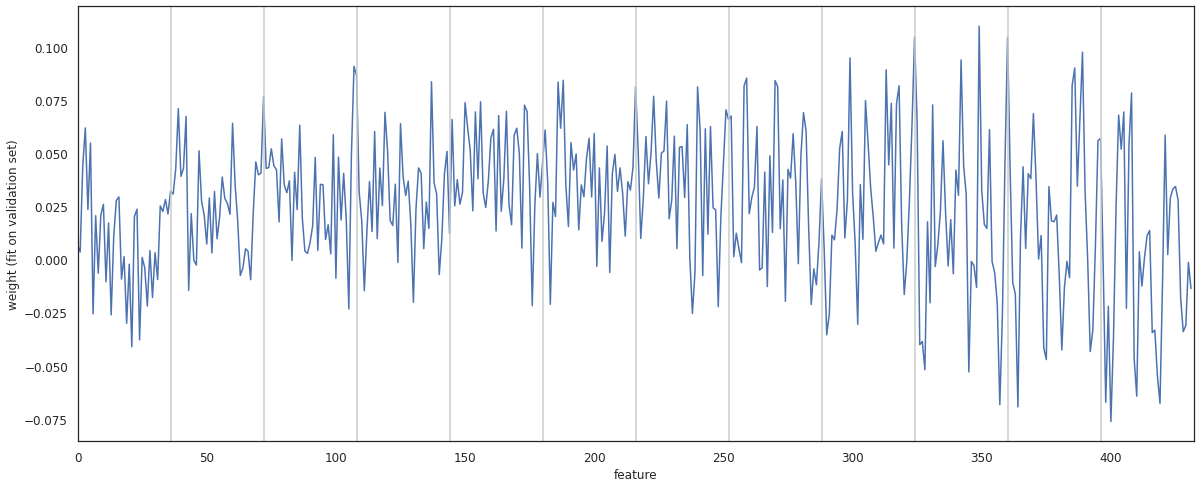

In [83]:
# Now projecting weights *back* into original feature space, based on the weight matrix from PCA...

weights_projected = weights_from_val @ pca_wts[0:ncompneeded,:]

plt.figure(figsize=(20,8));
plt.plot(weights_projected)

for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('weight (fit on validation set)')

Text(0.5, 1.0, 'vox 5908')

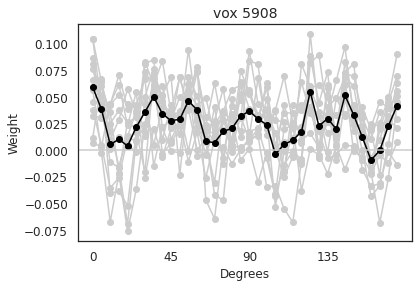

In [84]:
# averaging over orientation

weights_proj_reshaped = np.reshape(weights_projected, [n_ori, n_sf], order='F')

plt.plot(orients_deg, weights_proj_reshaped,'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  np.mean(weights_proj_reshaped,axis=1),'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model wts each feature channel\n(lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([0,1])
plt.title('vox %d'%vidx)

Text(0, 0.5, 'voxel correlation with this feature')

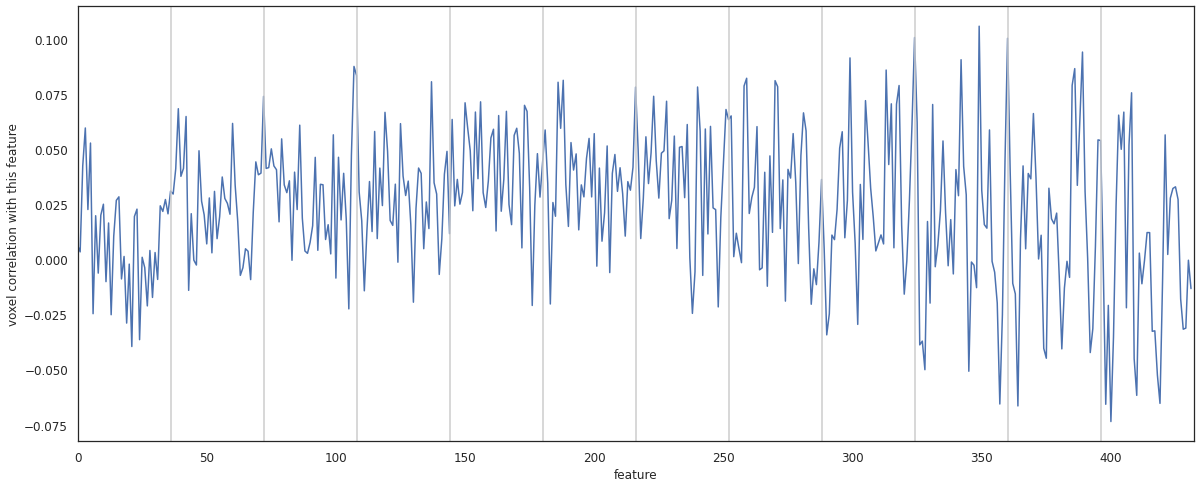

In [85]:
# Now projecting correlations *back* into original feature space, based on the weight matrix from PCA...

corrs_projected = voxel_pcafeat_correlations_val @ pca_wts[0:ncompneeded,:]

plt.figure(figsize=(20,8));
plt.plot(np.transpose(corrs_projected))
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('voxel correlation with this feature')

Text(0.5, 1.0, 'vox 5908')

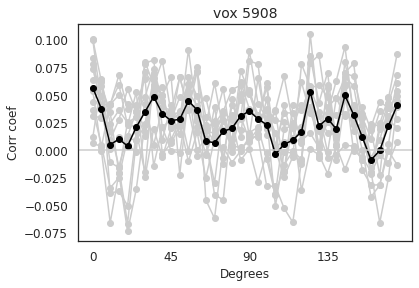

In [86]:
# averaging over orientation

corrs_proj_reshaped = np.reshape(corrs_projected, [n_ori, n_sf], order='F')

plt.plot(orients_deg, corrs_proj_reshaped,'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  np.mean(corrs_proj_reshaped,axis=1),'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Corr coef')
plt.title('Linear correlation with each feature channel\n(lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([0,1])
plt.title('vox %d'%vidx)

In [321]:
import sklearn

running pca (original size 1491 by 432)
61


Text(0, 0.5, 'cumulative var expl')

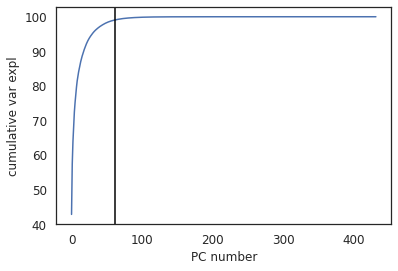

In [314]:
# trying pca to decorrelate features...
from sklearn import decomposition
pca = decomposition.PCA()
val_features_actual = features_each_model_val[:,:,best_model_ind]
print('running pca (original size %d by %d)'%(np.shape(val_features_actual)[0], np.shape(val_features_actual)[1]))
pca.fit(val_features_actual)
scores = pca.transform(val_features_actual)
pca_wts = pca.components_
pct_expl_var = pca.explained_variance_
pct_expl_var = pct_expl_var/sum(pct_expl_var)*100

plt.figure();
plt.plot(np.cumsum(pct_expl_var))
ncompneeded = np.where(np.cumsum(pct_expl_var)>99)[0][0]
# ncompneeded = 432
feat_reduced = scores[:,0:ncompneeded]
plt.axvline(ncompneeded,color='k')
print(ncompneeded)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')

In [234]:
np.shape(val_features_actual)

(1491, 432)

(1491, 1)

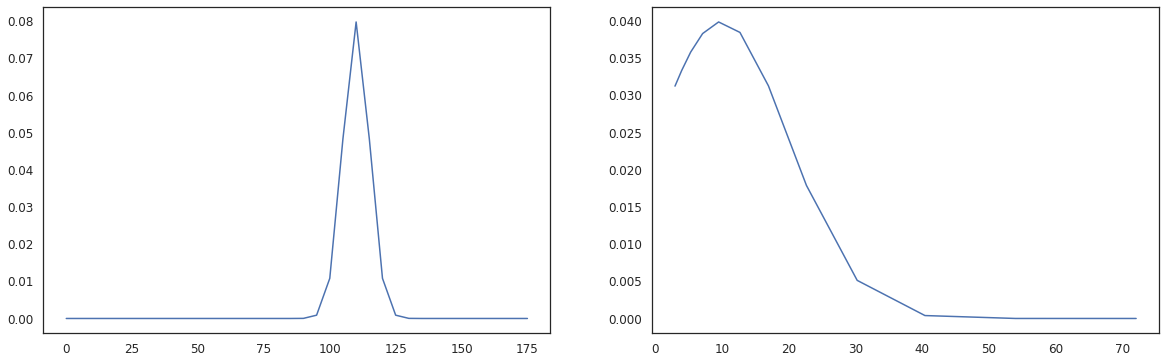

In [315]:
# making a simulated voxel with known response property

sim_pref_ori = 110
sim_pref_freq = 10
sim_orient_tuning = scipy.stats.norm.pdf(orients_deg,loc=sim_pref_ori, scale=5)
sim_freq_tuning = scipy.stats.norm.pdf(cyc_per_stim,loc=sim_pref_freq, scale=10)
plt.figure(figsize=(20,6));
plt.subplot(1,2,1)
plt.plot(orients_deg, sim_orient_tuning)
plt.subplot(1,2,2)
plt.plot(cyc_per_stim, sim_freq_tuning)

sim_voxel_feature_corrs = np.tile(np.expand_dims(sim_orient_tuning,1), [n_sf, 1]) * np.repeat(np.expand_dims(sim_freq_tuning,1), n_ori,axis=0)*10
# plt.subplot(1,3,3)
# plt.plot(sim_voxel_feature_corrs)

noise_level = 0.05
sim_voxel_data = scipy.stats.zscore(val_features_actual) @ sim_voxel_feature_corrs
sim_voxel_data  = sim_voxel_data + np.random.normal(0,noise_level, np.shape(sim_voxel_data))
np.shape(sim_voxel_data)

[0, 0.0]
[ 0.38804936  0.14325063 -0.02041332 -0.02752    -0.03049703]
0.9934898308273032


Text(0, 0.5, 'vox resp')

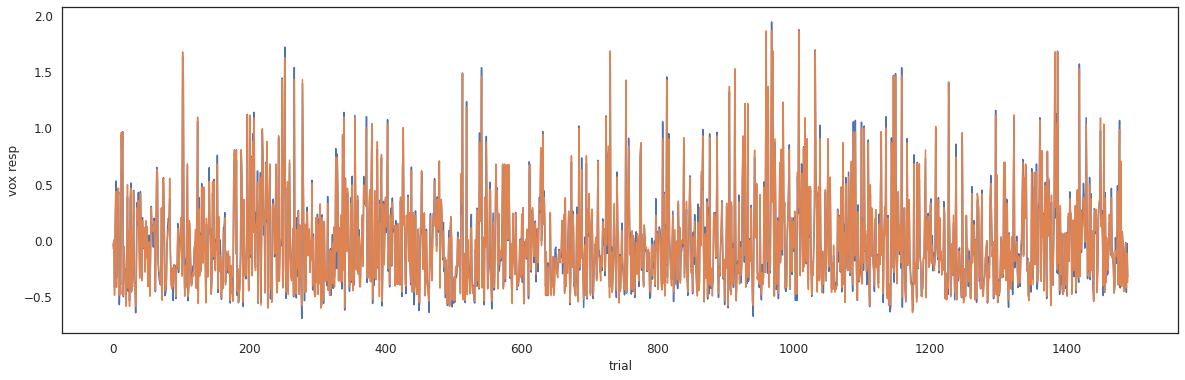

In [316]:
# Now fitting model to this simulated data

# z-score the features so they'll have equal variance...
feat_reduced_z = scipy.stats.zscore(feat_reduced,axis=0)
feat = np.concatenate([feat_reduced_z, np.ones((np.shape(feat_reduced)[0],1))], axis=1)
n_feat_reduced = np.shape(feat_reduced)[1]

lambdas2use = [0.0, 0.0]
_xval = _to_torch(feat, device=device)
_cof = _cofactor_fn_cpu(_xval, lambdas2use)
_vval = _to_torch(sim_voxel_data, device=device)
_betas, _loss = _loss_fn(_cof, _vval, _xval, _vval) 
lind = np.argmin(get_value(_loss))
w_est = get_value(_betas[lind,:,0])
print([lind, lambdas2use[lind]])
print(w_est[0:5])
weights_from_val = w_est[0:n_feat_reduced]
bias_from_val = w_est[n_feat_reduced]

sim_voxel_predicted = feat @ w_est
print(np.corrcoef(np.transpose(sim_voxel_data), np.transpose(sim_voxel_predicted))[0,1])

plt.figure(figsize=(20,6));
plt.plot(sim_voxel_data)
plt.plot(sim_voxel_predicted)
plt.xlabel('trial')
plt.ylabel('vox resp')

Text(0, 0.5, 'weight (fit on validation set)')

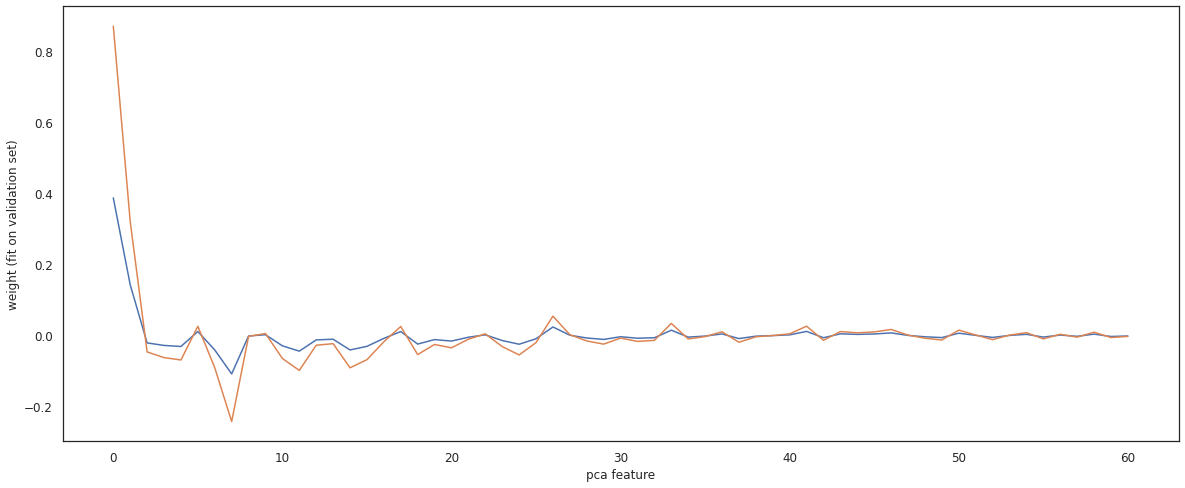

In [317]:
# Plotting encoding model wts versus features (computed on validation set )
# For pca'd, z-scored features, these are same.

plt.figure(figsize=(20,8));

plt.plot(weights_from_val)

# Assess the voxel's correlation w these reduced-dimensionality features

voxel_pcafeat_correlations_val = np.zeros((1, n_feat_reduced),dtype=fpX)
features2use = feat_reduced_z

for ff in range(n_feat_reduced):        
    voxel_pcafeat_correlations_val[0,ff] = np.corrcoef(features2use[:,ff], np.transpose(sim_voxel_data))[0,1]

plt.plot(voxel_pcafeat_correlations_val[0,:])

plt.xlabel('pca feature')
plt.ylabel('weight (fit on validation set)')

Text(0, 0.5, 'weight (fit on validation set)')

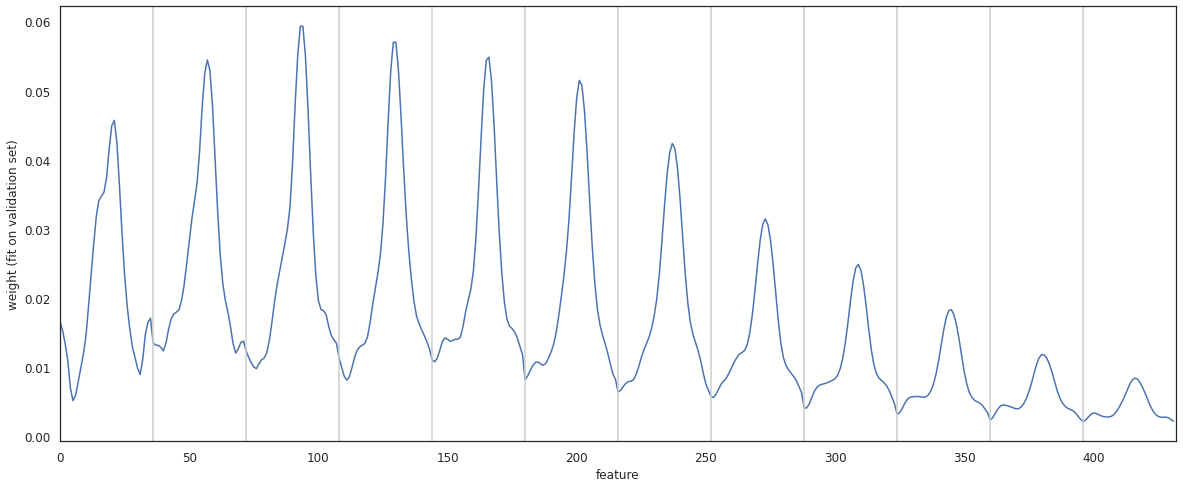

In [318]:
# Now projecting weights *back* into original feature space, based on the weight matrix from PCA...

weights_projected = weights_from_val @ pca_wts[0:ncompneeded,:]

plt.figure(figsize=(20,8));
plt.plot(weights_projected)

for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('weight (fit on validation set)')

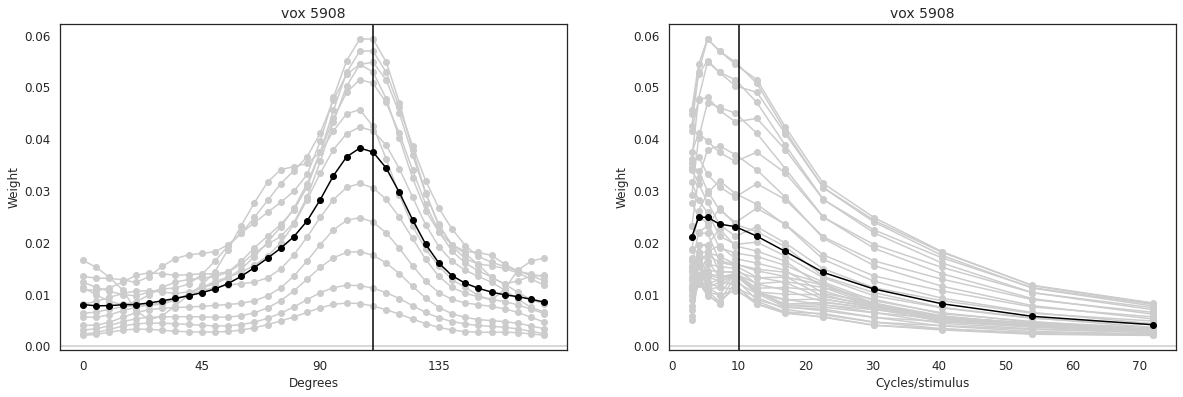

In [319]:
# averaging over orientation and SF

weights_proj_reshaped = np.reshape(weights_projected, [n_ori, n_sf], order='F')

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(orients_deg, weights_proj_reshaped,'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  np.mean(weights_proj_reshaped,axis=1),'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model wts each feature channel\n(lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([0,1])
plt.title('vox %d'%vidx)
plt.axvline(sim_pref_ori, color='k')

plt.subplot(1,2,2)
plt.plot(cyc_per_stim, np.transpose(weights_proj_reshaped),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim,  np.mean(weights_proj_reshaped,axis=0),'-o',color='k')
plt.xlabel('Cycles/stimulus')
plt.ylabel('Weight')
plt.title('Encoding model wts each feature channel\n(lines are diff orients)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.title('vox %d'%vidx)
plt.axvline(sim_pref_freq, color='k')

In [130]:
# snippet of code for manually computing covariance matrix

cov1 = np.cov(np.transpose(val_features_actual))
print(np.shape(cov1))

print(np.mean(val_features_actual,0)[0:2])
feat_centered = val_features_actual - np.tile(np.expand_dims(np.mean(val_features_actual,0),0),[np.shape(val_features_actual)[0],1])
print(np.mean(feat_centered,0)[0:2])
cov2 = (np.transpose(feat_centered) @ feat_centered)/(np.shape(feat_centered)[0]-1)
print(np.shape(cov2))

(432, 432)
[0.01479006 0.01412364]
[-3.9601511e-10 -2.8707972e-09]
(432, 432)


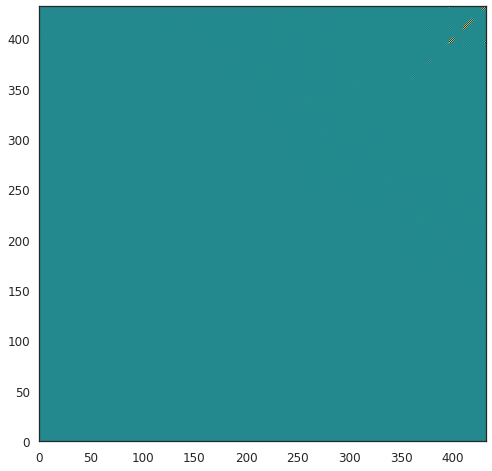

In [93]:
# snippet of code trying to compute sort of whitening transformation...

# whitening = np.cov(np.transpose(val_features_actual))**(-0.5)
# whitening = np.linalg.pinv(np.cov(np.transpose(val_features_actual)))
# feat = val_features_actual @ whitening
# feat = np.concatenate([feat, np.ones((np.shape(feat)[0],1))], axis=1)

plt.figure(figsize=(8,8));
# whitening = np.cov(np.transpose(val_features_actual))**(-0.5)
whitening = np.linalg.pinv(np.cov(np.transpose(val_features_actual)))
feat = val_features_actual @ whitening
feat = np.concatenate([feat, np.ones((np.shape(feat)[0],1))], axis=1)
cov_whitened = np.cov(np.transpose(feat[:,0:432]))
plt.pcolormesh(cov_whitened)